# Fundamentals of Machine Learning - Horst R. Tomás

In [657]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Problem

You are provided with a dataset which contains observations on 30m by 30m spacial cells
containing different kinds of trees. The target variable reflect the most frequent tree class in a
given cell. The predictor variables provide different geographic information regarding that cell,
such as floor slope, distance to water bodies or possible fire spots, etc

Your task is to build a machine learning model to predict the vegetation classes
as best as you can. You are expected to describe as much as you can the modeling process,
use figures liberally to convey information and, most important of all, provide an estimate for
the prediction error.

## Data

The dataset is provided as a zipped csv file(train_r1.csv). Consider this dataset as your training/validation
partition (you may partition it as you like). After the report deadline
you will be given a test dataset to compare with you validation score, which will serve as an
external assesment of your models performance.

All columns are measurements in meters, except columns 2 and 3 which are in degrees and
7, 8 and 9, which are in 256 values (integers in the interval [0, 255]). Columns 11, 12 and 13
are categorical (i.e., integers represent classes).

In [658]:
#Leyendo el archivo csv
frames = pd.read_csv('train_r1.csv')
frames.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_area_silvestre,clase_suelo,dosel_forestal
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
2,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
3,2595,45,2,153,-1,391,220,234,150,6172,1,29,5
4,2579,132,6,300,-15,67,230,237,140,6031,1,29,2


In [659]:
#Quisiera particionar en 82% train y 18% test
#Ver si realmente me conviene 42 en random_state..
frames_train, frames_test = train_test_split(frames, test_size=0.18, random_state=42)

In [660]:
#Primero quiero ver si hay valores nulos y nans
frames_train.isnull().sum()
#No hay valores nulos

altura                  0
exposicion              0
inclinacion_suelo       0
distancia_agua          0
altura_agua             0
distancia_caminos       0
sombra_maniana          0
sombra_mediodia         0
sombra_tarde            0
distancia_fuego         0
clase_area_silvestre    0
clase_suelo             0
dosel_forestal          0
dtype: int64

In [661]:
#Quiero ver si hay valores Nans
frames_train.isna().sum()
#No hay valores Nans

altura                  0
exposicion              0
inclinacion_suelo       0
distancia_agua          0
altura_agua             0
distancia_caminos       0
sombra_maniana          0
sombra_mediodia         0
sombra_tarde            0
distancia_fuego         0
clase_area_silvestre    0
clase_suelo             0
dosel_forestal          0
dtype: int64

In [662]:
#Quiero ver si hay valores repetidos
frames_train.duplicated().sum()
#No hay valores repetidos

0

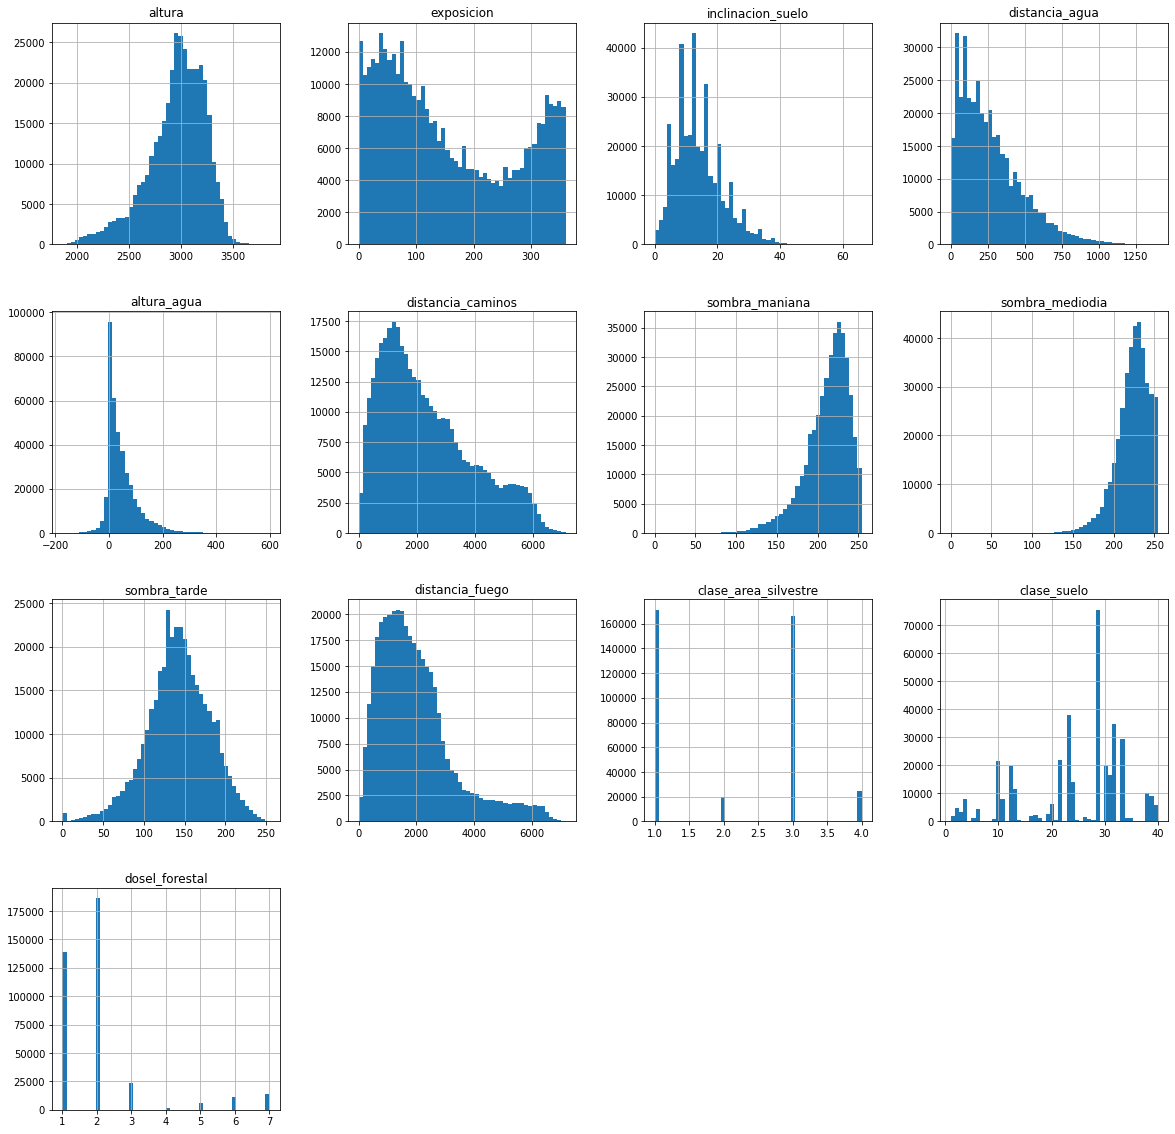

In [663]:
#Haré algunas visualizaciones de los datos de entrenamiento
#plotear un histograma de cada atributo
frames_train.hist(bins=50,figsize=(20,20))
plt.show()

In [664]:
#Chequearé la correlación sobre dosel_forestal
corr = frames_train.corr()
corr.sort_values(["dosel_forestal"], ascending = False, inplace = True)
print(corr.dosel_forestal)

dosel_forestal          1.000000
clase_area_silvestre    0.276734
inclinacion_suelo       0.146935
altura_agua             0.080429
exposicion              0.017895
distancia_agua         -0.021102
sombra_maniana         -0.034461
sombra_tarde           -0.048294
sombra_mediodia        -0.095213
distancia_fuego        -0.108896
distancia_caminos      -0.153348
clase_suelo            -0.163892
altura                 -0.268635
Name: dosel_forestal, dtype: float64


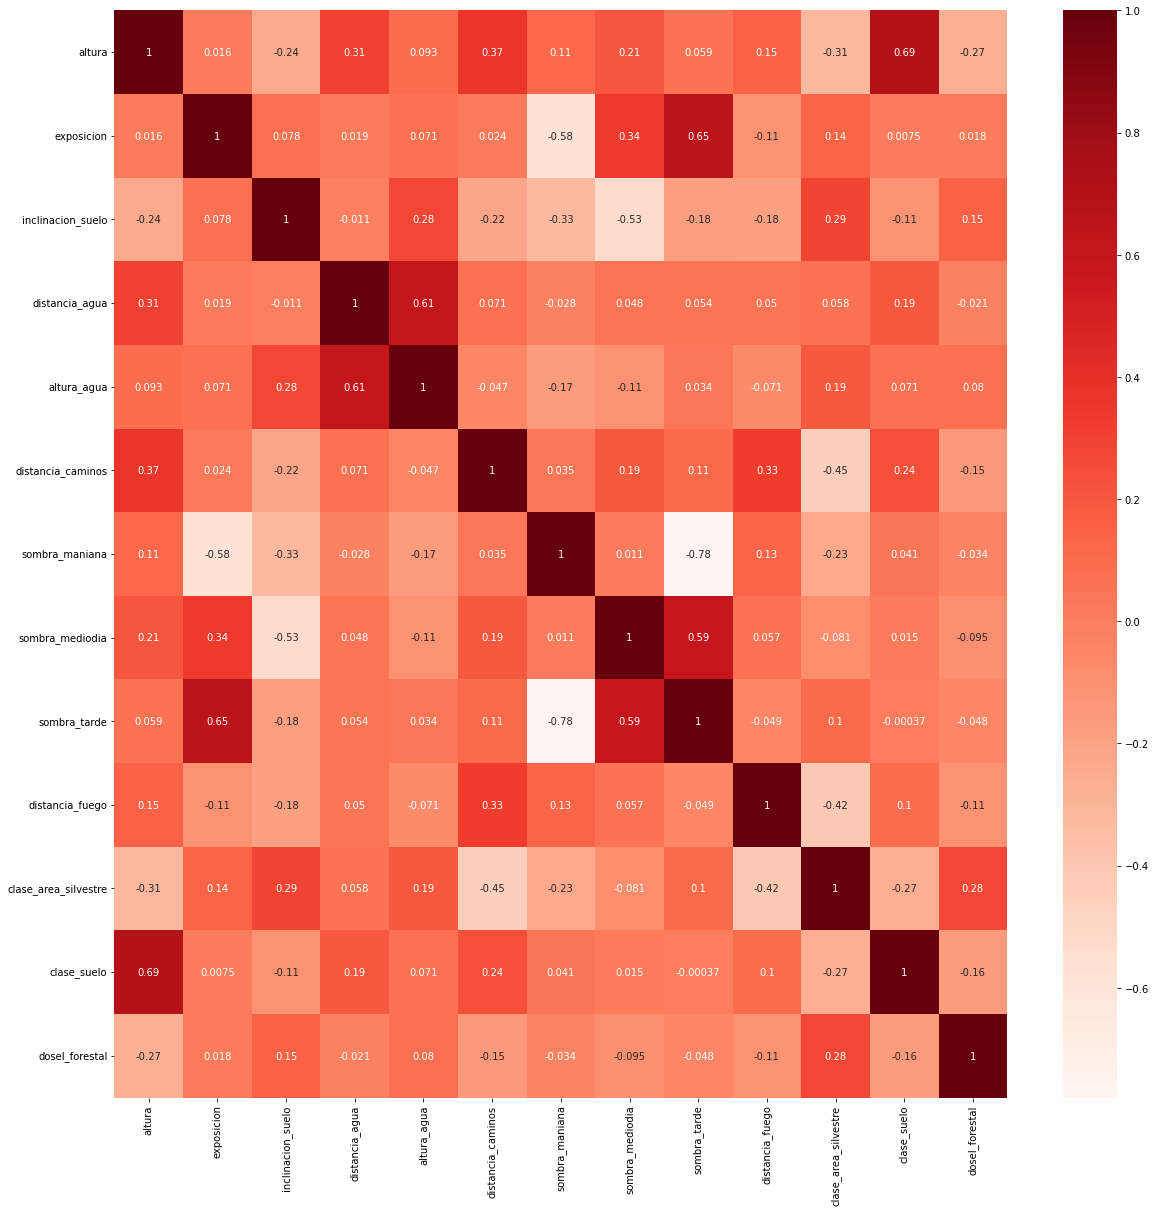

In [665]:
#Plot correlation matrix
corr_matrix = frames_train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Podría agregar un nuevo atributo a frames_train y frames_test que sea la suma en distancia euclideana de distancia_agua y altura_agua.
Dado que ambos atributos tienen valores en las mismas unidades, podría ser una buena idea. Implementación:

frames_train['distancia_total_agua'] = np.sqrt(frames_train['distancia_agua']**2 + frames_train['altura_agua']**2)
frames_test['distancia_total_agua'] = np.sqrt(frames_test['distancia_agua']**2 + frames_test['altura_agua']**2)

#Ahora dropearé los atributos distancia_agua y altura_agua
frames_train = frames_train.drop(columns=['distancia_agua', 'altura_agua'])
frames_test = frames_test.drop(columns=['distancia_agua', 'altura_agua'])

Quiero saber con que está correlacionada exposicion. Implementacion:

corr = frames_train.corr()
corr.sort_values(["exposicion"], ascending = False, inplace = True)
print(corr.exposicion)

#Al parecer está muy correlacionada con las sombras, por lo que la dropeo(Ya intenté combinarlas y nunca mejoró el accuracy)
frames_train = frames_train.drop(columns=['exposicion'])
frames_test = frames_test.drop(columns=['exposicion'])

In [666]:
#Probaré dropear sólo las sombras, sombra_maniana, sombra_tarde, sombra_mediodia. Estos atributos están
#muy poco correlacionados con dosel_forestal
frames_train = frames_train.drop(columns=['sombra_maniana', 'sombra_tarde', 'sombra_mediodia'])
frames_test = frames_test.drop(columns=['sombra_maniana', 'sombra_tarde', 'sombra_mediodia'])


# Entrenamiento:

You are allowed to experiment with two specific models: random forests and xgboost.
You can play around with whichever combination of feature engineering, fine tuning, or any
modeling step that you see appropriate, as long as it is well documented.

In [668]:
#Aplicando random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
#max_depth es la profundidad máxima de cada árbol
#n_estimators es la cantidad de árboles que se van a crear
#random_state es la semilla para el generador de números aleatorios

#Entrenando el modelo
rf.fit(frames_train.drop(columns=['dosel_forestal']), frames_train['dosel_forestal'])

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=42)

Mi compu no se banca para que sean muchos árboles profundos, así que a mis comparaciones las haré con pocos árboles y poca profundidad.
Cabe resaltar que utilizaré la misma cantidad de árboles y profundidad para el método de entrenamiento de XGBoost.

In [ ]:
#Aplicaré Cross Validation para ver si el modelo está overfitteando
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

scores = cross_val_score(rf, frames_train.drop(columns=['dosel_forestal']), frames_train['dosel_forestal'], cv=10)
#cv es la cantidad de folds que se van a crear
print("Accuracy: %f (+/- %f)" % (scores.mean(), scores.std() * 2))

In [669]:
#Veré las importancias de los atributos
feature_importances = pd.DataFrame(rf.feature_importances_,
                                      index = frames_train.drop(columns=['dosel_forestal']).columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


                      importance
altura                  0.439981
clase_suelo             0.251056
clase_area_silvestre    0.090485
distancia_caminos       0.086915
exposicion              0.042314
distancia_agua          0.039407
altura_agua             0.027449
inclinacion_suelo       0.022394


In [670]:
#Matriz de confusion
from sklearn.metrics import confusion_matrix
y_pred = rf.predict(frames_test.drop(columns=['dosel_forestal']))
confusion_matrix(frames_test['dosel_forestal'], y_pred)


array([[22911,  7400,     8,     0,     2,     1,   243],
       [ 6166, 34047,   270,     1,    14,    85,    41],
       [    0,   483,  4632,    25,     0,   144,     0],
       [    0,     0,   178,   210,     0,     5,     0],
       [   20,  1133,    28,     0,   149,     0,     0],
       [    2,   639,   998,     8,     0,   910,     0],
       [ 1048,    26,     0,     0,     0,     0,  1839]], dtype=int64)

In [671]:
#Report de clasificación, veré los recall
from sklearn.metrics import classification_report
print(classification_report(frames_test['dosel_forestal'], y_pred))

              precision    recall  f1-score   support

           1       0.76      0.75      0.75     30565
           2       0.78      0.84      0.81     40624
           3       0.76      0.88      0.81      5284
           4       0.86      0.53      0.66       393
           5       0.90      0.11      0.20      1330
           6       0.79      0.36      0.49      2557
           7       0.87      0.63      0.73      2913

    accuracy                           0.77     83666
   macro avg       0.82      0.59      0.64     83666
weighted avg       0.78      0.77      0.77     83666



In [672]:
#Acuraccy
from sklearn.metrics import accuracy_score
accuracy_score(frames_test['dosel_forestal'], y_pred)


0.7732890301914757

Acurracy:

RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42):

-Sin dropear nada
0.7849305572155953

-Dropeando exposicion, sombra maniana y sombra tarde
0.7813568235603471

-Agreagando distancia_agua_total y Dropeando distancia_agua y altura_agua
0.7898668515286974

-Agreagando distancia_agua_total y Dropeando distancia_agua y altura_agua y exposicion
0.7898190423828079

Veo que empeoró un poquito el accurracy al droppear exposicion, pero no mucho.

-Dropeando sólo las sombras
0.7931776348815528

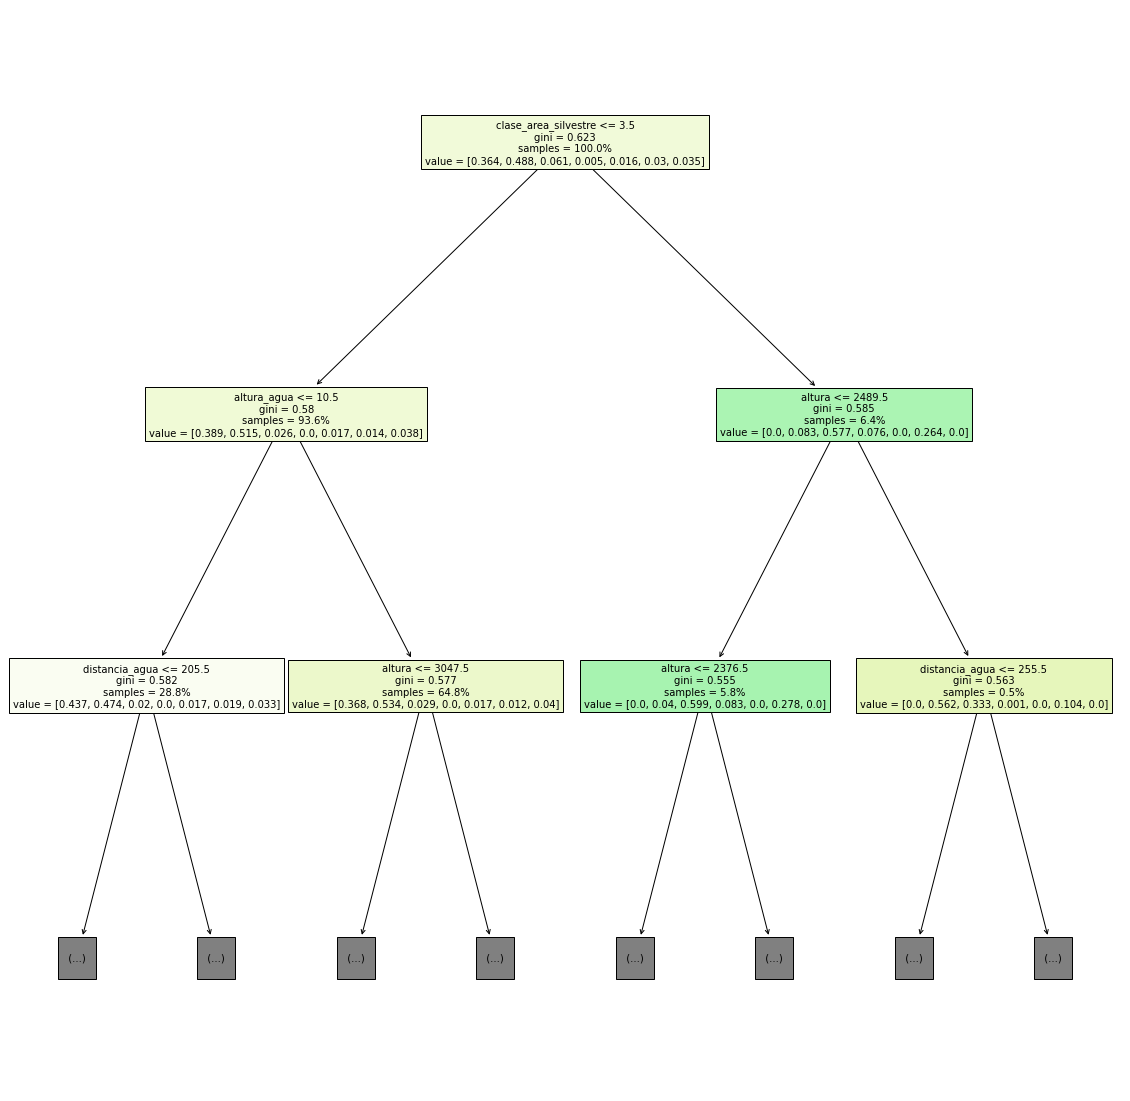

In [673]:
#Ploteare el árbol de decisión con una profundidad de 2 para tener una idea de como está funcionando
from sklearn import tree
plt.figure(figsize=(20,20))
tree.plot_tree(rf.estimators_[0], max_depth=2, feature_names=frames_train.columns, proportion=True, filled=True, fontsize=10)
plt.show()

In [675]:
#Ahora aplicaré XGBoost
frames_train_xgb = frames_train
frames_test_xgb = frames_test

#XGBoost no acepta valores categóricos, por lo que los codificaré con LabelEncoder (Por ésto utilizo nuevos dataframes)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
frames_train_xgb['clase_area_silvestre'] = le.fit_transform(frames_train_xgb['clase_area_silvestre'])
frames_train_xgb['clase_suelo'] = le.fit_transform(frames_train_xgb['clase_suelo'])
frames_train_xgb['dosel_forestal'] = le.fit_transform(frames_train_xgb['dosel_forestal'])
frames_test_xgb['clase_area_silvestre'] = le.fit_transform(frames_test_xgb['clase_area_silvestre'])
frames_test_xgb['clase_suelo'] = le.fit_transform(frames_test_xgb['clase_suelo'])
frames_test_xgb['dosel_forestal'] = le.fit_transform(frames_test_xgb['dosel_forestal'])

#Entrenando con XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=25, n_estimators=100, random_state=42)
xgb_model.fit(frames_train_xgb.drop(columns=['dosel_forestal']), frames_train_xgb['dosel_forestal'])


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, ...)

In [676]:
#Matriz de confusion
from sklearn.metrics import confusion_matrix
y_pred_2 = xgb_model.predict(frames_test_xgb.drop(columns=['dosel_forestal']))
confusion_matrix(frames_test_xgb['dosel_forestal'], y_pred_2)


array([[25319,  5055,     5,     0,     9,    11,   166],
       [ 4249, 35964,   163,     0,    96,   140,    12],
       [    3,   248,  4763,    26,     2,   242,     0],
       [    0,     0,    54,   330,     0,     9,     0],
       [   23,   648,    19,     0,   634,     6,     0],
       [    3,   204,   523,    12,     0,  1815,     0],
       [  330,    18,     0,     0,     1,     0,  2564]], dtype=int64)

In [677]:
#Report de clasificación, veré los recall
from sklearn.metrics import classification_report
print(classification_report(frames_test_xgb['dosel_forestal'], y_pred_2))


              precision    recall  f1-score   support

           0       0.85      0.83      0.84     30565
           1       0.85      0.89      0.87     40624
           2       0.86      0.90      0.88      5284
           3       0.90      0.84      0.87       393
           4       0.85      0.48      0.61      1330
           5       0.82      0.71      0.76      2557
           6       0.94      0.88      0.91      2913

    accuracy                           0.85     83666
   macro avg       0.87      0.79      0.82     83666
weighted avg       0.85      0.85      0.85     83666



In [678]:
#acuraccy
from sklearn.metrics import accuracy_score
accuracy_score(frames_test_xgb['dosel_forestal'], y_pred_2)


0.8532617789783186

Acurracy:

xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=20, random_state=42):

-Sin dropear nada
0.884242105514785

-Agreagando distancia_agua_total y Dropeando distancia_agua y altura_agua
0.8833695886022996

-Agreagando distancia_agua_total y Dropeando distancia_agua y altura_agua y exposicion
0.884660435541319

Veo que mejoró un poquito el accurracy al droppear exposicion, pero no mucho.

-Dropeando sólo exposicion
0.885222193005522

-Dropeando sólo las sombras
0.8868477039657686

Ésto abre nuevas posibilidades, al hacer feature engenieering puedo mejorar algún entrenamiento pero empeorar otro...


In [679]:
#Veré las importancias de los atributos
feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                        index = frames_train_xgb.drop(columns=['dosel_forestal']).columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                      importance
clase_suelo             0.322007
altura                  0.267127
clase_area_silvestre    0.176136
distancia_caminos       0.064293
distancia_agua          0.055075
exposicion              0.044857
altura_agua             0.038055
inclinacion_suelo       0.032450


In [ ]:
#Por último voy a probar con un árbol de decisión:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=25, random_state=42)
tree_clf.fit(frames_train.drop(columns=['dosel_forestal']), frames_train['dosel_forestal'])

#Accuracy
y_pred_3 = tree_clf.predict(frames_test.drop(columns=['dosel_forestal']))
accuracy_score(frames_test['dosel_forestal'], y_pred_3)

#Da menos accurracy que random forest y que XGBoost

In [ ]:
#Guardaré con pickle los modelos propuestos, para n=100 y max_depth=25
import pickle
pickle.dump(rf, open('random_forest.sav', 'wb'))
pickle.dump(xgb_model, open('xgboost.sav', 'wb'))